In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import average_precision_score
import pandas as pd
import numpy as np
from copy import deepcopy
import seaborn as sns
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc, precision_score, recall_score


2023-03-23 11:49:16.637988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 11:49:16.691313: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 11:49:16.693016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-23 11:49:16.693023:

### Loading Data + Visualization

In [2]:
# df = pd.read_csv('./robot_data/merged_robot_data.csv')
# df = pd.read_csv('./robotdatacollection3/merged_robot_data_100episodes.csv')
# df = pd.read_csv('./sim_data_collection_feb7/100_sim_feb7.csv')
# df = pd.read_csv('./data_collection4/merged_sim_data.csv')
df = pd.read_csv('./Thesis/classifier_90.csv')

In [3]:
undersample = False
use_weights = True

In [4]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx', 'ry', 'rz',
       'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'Case'],
      dtype='object')

In [5]:
df.shape

(372031, 19)

In [6]:
# df = df.drop(['Unnamed: 0.2', 'Unnamed: 0.1','Unnamed: 0','t'], axis=1)
df = df.drop(['Unnamed: 0.1','Unnamed: 0','t'], axis=1)
# df = df.drop(['Unnamed: 0','t'], axis=1)


In [7]:
df.columns

Index(['x', 'y', 'z', 'rx', 'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz',
       'Mx', 'My', 'Mz', 'Case'],
      dtype='object')

In [8]:
tot = len(df.Case)
pos = df.Case.sum()
neg = tot-pos
print('Total data: ', tot)
print(f'Label: 0 {neg} | {(neg/tot)*100}%')
print(f'Label: 1 {pos} | {(pos/tot)*100}%')

Total data:  372031
Label: 0 366801 | 98.5942031712411%
Label: 1 5230 | 1.4057968287588938%


In [9]:
df.describe()

,x,y,z,rx,ry,rz,vx,vy,vz,Fx,Fy,Fz,Mx,My,Mz
count,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000
mean,-0.138157,-0.509673,0.072302,0.000131,-0.000311,0.000474,-0.000023,0.000018,-0.000017,-0.354220,-0.144643,4.989051,0.005260,-0.018391,0.006327
std,0.003047,0.002955,0.000079,0.001924,0.002005,0.005790,0.001140,0.001214,0.000602,1.053794,1.266742,0.879046,0.138463,0.144498,0.113629
min,-0.144842,-0.516395,0.068149,-0.015699,-0.013300,-0.014431,-0.007146,-0.006603,-0.023657,-5.893762,-9.714105,-0.537690,-1.217870,-1.444511,-0.294400
25%,-0.140399,-0.511933,0.072288,-0.001272,-0.001982,-0.004872,-0.001091,-0.001033,-0.000150,-1.196908,-1.094954,4.608072,-0.099464,-0.132466,-0.055399
50%,-0.138189,-0.509794,0.072305,0.000127,-0.000251,0.001839,-0.000058,0.000038,-0.000002,-0.368335,-0.052817,4.978326,0.011537,-0.017958,0.003410
75%,-0.135929,-0.507547,0.072320,0.001797,0.001417,0.005477,0.001022,0.001104,0.000143,0.485567,0.929513,5.353946,0.126140,0.099284,0.074197
max,-0.131389,-0.502661,0.072926,0.003593,0.007917,0.015166,0.004523,0.006503,0.005934,8.236035,6.991087,14.483513,0.352819,0.867845,0.296962


In [10]:
# corr = df.corr()
# plt.figure(figsize=(15,10))
# sns.heatmap(corr,annot=True)
# plt.show()

In [11]:
# corr_with_case = corr['Case']
# # delete .abs() if we do not want abs values
# sorted_corr = corr_with_case.abs().sort_values(ascending=False)

# corr_df = pd.DataFrame(sorted_corr)

# # rename the column
# corr_df = corr_df.rename(columns={'case': 'correlation'})

In [12]:
# corr_df

In [13]:
class_count_0, class_count_1 = df['Case'].value_counts()

In [14]:
class_0 = df[df['Case'] == False]
class_1 = df[df['Case'] == True]

In [15]:
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (366801, 16)
class 1: (5230, 16)


Undersampling

In [16]:
if undersample:
    class_0_under = class_0.sample(class_count_1)

    test_under = pd.concat([class_0_under, class_1], axis=0)
    test_under['Case'].value_counts()
    df = test_under
    print('Undersampling!')

### Data Preprocessing

In [17]:
feature_names = ['Fx', 'Fy', 'Fz', 'Mx', 'My']
# feature_names = ['fz']
# 
# feature_names = ['fx', 'fy', 'fz', 'mx', 'my']

X_df = df[feature_names]
y = df.Case.to_numpy()

# moving average
# roll = 30
# X_df = X_df.rolling(roll).mean()
# X_df = X_df.loc[roll-1:]
# y = y[roll-1:]


X = X_df.to_numpy()

window_len = 100#300

if window_len:
    n_features = len(feature_names)  # 3

    row = X.shape[0] + 1 - window_len
    col_len = n_features * window_len
    new_x = np.zeros((row, col_len))
    new_y = np.zeros((row, 1))

    for i in range(len(new_x)):
        new_x[i] = X[i:i + window_len].reshape(1, col_len)[0][::-1]
        new_y[i] = y[i + (window_len - 1)]

    y = deepcopy(new_y)
    X = deepcopy(new_x)

total = len(y)
pos = int(y.sum())
neg = total - pos
# weight = neg/pos # 13.5

In [18]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.51
Weight for class 1: 35.56


In [19]:
X_df.describe()

,Fx,Fy,Fz,Mx,My
count,372031.000000,372031.000000,372031.000000,372031.000000,372031.000000
mean,-0.354220,-0.144643,4.989051,0.005260,-0.018391
std,1.053794,1.266742,0.879046,0.138463,0.144498
min,-5.893762,-9.714105,-0.537690,-1.217870,-1.444511
25%,-1.196908,-1.094954,4.608072,-0.099464,-0.132466
50%,-0.368335,-0.052817,4.978326,0.011537,-0.017958
75%,0.485567,0.929513,5.353946,0.126140,0.099284
max,8.236035,6.991087,14.483513,0.352819,0.867845


In [20]:
# df.Fy.loc[:1000].plot()
# X_df.Fy.loc[:1000].plot()

In [21]:
print(X.shape)
print(y.shape)

(371932, 500)
(371932, 1)


In [22]:
print(f"Total Dataset size: {X.shape}")
print(f"Ratio of 1's in dataset {(pos/total) * 100}% and count is: {pos}")
print(f"Ratio of 0's in dataset {(neg/total) * 100}% and count is: {neg}")

Total Dataset size: (371932, 500)
Ratio of 1's in dataset 1.4061710205091253% and count is: 5230
Ratio of 0's in dataset 98.59382897949087% and count is: 366702


### Helper Functions

In [23]:
def plot_prc_and_roc(y_true, y_pred):

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=1.0, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.1, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid()

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
              average_precision))
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
            Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()       


In [24]:
def plot_precision_recall_vs_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_vec = 2 * (precisions * recalls) / (precisions + recalls)
    plt.figure()
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.plot(thresholds, f1_vec[:-1], "k-", label='F1')
    plt.xlabel('Threshold')
    plt.title('Precision/ Recall/ F1 Score/ Threshold')
    plt.legend()
    plt.grid()
    plt.show()

In [25]:
def dnn_stratified_kfold_cross_val(X, y, epoch, batch_size, callback, print_info, metrics):
    """
    StratifiedKFold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    aucpr_scores = []
    roc_scores = []
    prec_scores =  []
    recall_scores = []

    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold_id}:")
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if print_info:
            print(f"Ratio of 1's in train set {np.round((y_train.sum())/len(y_train),4) * 100}%")
            print(f"Ratio of 1's in validation set {np.round((y_valid.sum()/len(y_valid)),4) * 100}%")
        
        n_inputs = X_train.shape[1]  
        # make model
        model = make_model(n_inputs, metrics=metrics)
        # fit model
        model_history = model.fit(X_train, y_train,
                          validation_data = (X_valid, y_valid),
                          epochs=epoch,
                          batch_size=batch_size,
                          verbose=0, # 1 
                          callbacks=[callback],
                          shuffle=True) 
        
        y_val_pred = model.predict(X_valid)
        roc = roc_auc_score(y_valid, y_val_pred)
        aucpr = average_precision_score(y_valid, y_val_pred)
        prec = precision_score(y_valid, y_val_pred > 0.5)
        recall = recall_score(y_valid, y_val_pred > 0.5)
        if print_info:
            print('--------------------------------------')
            print(f"Aucpr score for fold {fold_id} is : {aucpr}")
            print(f"ROC score for fold {fold_id} is : {roc}")
            print(f"Precision  : {prec}")
            print(f"Recall : {recall}")
            print('--------------------------------------')

        aucpr_scores.append(aucpr)
        roc_scores.append(roc)
        prec_scores.append(prec)
        recall_scores.append(recall)


    print()
    print(f"Mean across all folds:\nAUCPR: {np.mean(aucpr_scores)}\nROC {np.mean(roc_scores)}\nPrecision: {np.mean(prec_scores)}\nRecall: {np.mean(recall_scores)}")


In [26]:
def get_scores_thresholds(X_test, y_test, model, algo=None):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for thresh in thresholds:
        if algo == "XGB":
            y_pred = model.predict_proba(X_test)[:, 1]
        else:
            y_pred = model.predict(X_test)
            
        print('threshold:', thresh)
        print(confusion_matrix(y_test, y_pred > thresh))
        print(classification_report(y_test, y_pred > thresh))
        print('--------------------------------------')

### Define Model

In [27]:
tf.random.set_seed(42)


In [29]:
def make_model(n_inputs, metrics=None, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    nn = keras.Sequential()
    nn.add(keras.layers.Dense(32, input_shape=(n_inputs,), activation='relu'))
    nn.add(keras.layers.Dense(64, activation='relu'))
    nn.add(keras.layers.Dense(256, activation='relu'))

    nn.add(keras.layers.Dense(128, activation='relu'))
#     nn.add(keras.layers.Dense(256, activation='relu'))
#     nn.add(keras.layers.Dense(64, activation='relu'))
#     nn.add(keras.layers.Dense(16, activation='relu'))
    nn.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    # testing to reduce overfit
#     nn.add(keras.layers.Dropout(0.1))
    
    nn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=metrics)
    # metrics simply tell us what we will be able to see in the log and on plot
    # they do are NOT used for optimization!

    
    return nn

In [30]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2023-03-23 11:50:51.318191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-23 11:50:51.318220: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 11:50:51.318243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-n8-room20): /proc/driver/nvidia/version does not exist
2023-03-23 11:50:51.318796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [31]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', # validation precision 
    mode='max', # specify whether we seek to min/max given metrics
    verbose=1,  # print training epoch on which we stopped
    patience=20, #after how many epochs of no improvement do we stop
    restore_best_weights=True)


##### Stratified 10 fold cross validation of different models

In [32]:
# # create and compile network
# n_inputs = X.shape[1]  # (77862, 3)
# dnn = make_model(n_inputs, metrics=METRICS)
# batch_size_list = [512, 1024]
# for bs in batch_size_list:
# # perform statified k fold validation
#     print('Batch Size', bs)
#     dnn_stratified_kfold_cross_val(X, y, epoch=300, 
#                                batch_size=bs, callback=early_stopping, 
#                                print_info=True, metrics=METRICS)

### Chosing one of the models

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [34]:
print(f"% of 1's in train set {y_train.sum()/len(y_train)*100}")
print(f"% of 1's in test set {y_test.sum()/len(y_test)*100}")

% of 1's in train set 1.4061738560553867
% of 1's in test set 1.406159678438437


In [35]:
X_train.shape

(297545, 500)

In [36]:
X_test.shape

(74387, 500)

In [37]:
n_inputs = X_train.shape[1]  # (77862, 3)
print('Input shape',n_inputs)
model = make_model(n_inputs, metrics=METRICS)
print(model.summary())

Input shape 500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                16032     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,809
Trainable params: 67,809
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# sc = StandardScaler()
# X[num_cols] = sc.fit_transform(X[num_cols])
# test[num_cols] = sc.transform(test[num_cols])
# X = X.values
# y = y.values
# test = test.values


In [40]:
EPOCHS=300 #200
BATCH_SIZE=2048#,2048# 1024
if use_weights:
    print('Using weights!')
    model_history = model.fit(X_train, y_train,
                          validation_data = (X_test, y_test),
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          callbacks=[early_stopping],
                          shuffle=True,
                          class_weight=class_weight) 
else:
    model_history = model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              callbacks=[early_stopping],
                              shuffle=True) 

Using weights!
Epoch 1/300
146/146 [==============================] - 4s 25ms/step - loss: 0.4496 - tp: 3279.0000 - fp: 71353.0000 - tn: 222008.0000 - fn: 905.0000 - precision: 0.0439 - recall: 0.7837 - auc: 0.8625 - prc: 0.0935 - val_loss: 0.4766 - val_tp: 821.0000 - val_fp: 18419.0000 - val_tn: 54922.0000 - val_fn: 225.0000 - val_precision: 0.0427 - val_recall: 0.7849 - val_auc: 0.8573 - val_prc: 0.0843
Epoch 2/300
146/146 [==============================] - 3s 24ms/step - loss: 0.4439 - tp: 3277.0000 - fp: 68639.0000 - tn: 224722.0000 - fn: 907.0000 - precision: 0.0456 - recall: 0.7832 - auc: 0.8657 - prc: 0.0945 - val_loss: 0.4644 - val_tp: 809.0000 - val_fp: 17746.0000 - val_tn: 55595.0000 - val_fn: 237.0000 - val_precision: 0.0436 - val_recall: 0.7734 - val_auc: 0.8584 - val_prc: 0.0875
Epoch 3/300
146/146 [==============================] - 3s 24ms/step - loss: 0.4421 - tp: 3304.0000 - fp: 70401.0000 - tn: 222960.0000 - fn: 880.0000 - precision: 0.0448 - recall: 0.7897 - auc: 0.86

Epoch 22/300
146/146 [==============================] - 4s 24ms/step - loss: 0.4230 - tp: 3449.0000 - fp: 73532.0000 - tn: 219829.0000 - fn: 735.0000 - precision: 0.0448 - recall: 0.8243 - auc: 0.8793 - prc: 0.1116 - val_loss: 0.4381 - val_tp: 847.0000 - val_fp: 17813.0000 - val_tn: 55528.0000 - val_fn: 199.0000 - val_precision: 0.0454 - val_recall: 0.8098 - val_auc: 0.8741 - val_prc: 0.1011
Epoch 23/300
146/146 [==============================] - 3s 22ms/step - loss: 0.4217 - tp: 3461.0000 - fp: 73550.0000 - tn: 219811.0000 - fn: 723.0000 - precision: 0.0449 - recall: 0.8272 - auc: 0.8797 - prc: 0.1141 - val_loss: 0.4844 - val_tp: 893.0000 - val_fp: 21013.0000 - val_tn: 52328.0000 - val_fn: 153.0000 - val_precision: 0.0408 - val_recall: 0.8537 - val_auc: 0.8725 - val_prc: 0.0978
Epoch 24/300
146/146 [==============================] - 3s 24ms/step - loss: 0.4194 - tp: 3476.0000 - fp: 73474.0000 - tn: 219887.0000 - fn: 708.0000 - precision: 0.0452 - recall: 0.8308 - auc: 0.8811 - prc: 0.

Epoch 43/300
146/146 [==============================] - 4s 25ms/step - loss: 0.4057 - tp: 3518.0000 - fp: 69284.0000 - tn: 224077.0000 - fn: 666.0000 - precision: 0.0483 - recall: 0.8408 - auc: 0.8899 - prc: 0.1156 - val_loss: 0.5056 - val_tp: 939.0000 - val_fp: 21663.0000 - val_tn: 51678.0000 - val_fn: 107.0000 - val_precision: 0.0415 - val_recall: 0.8977 - val_auc: 0.8869 - val_prc: 0.1025
Epoch 44/300
146/146 [==============================] - 3s 19ms/step - loss: 0.4076 - tp: 3529.0000 - fp: 69856.0000 - tn: 223505.0000 - fn: 655.0000 - precision: 0.0481 - recall: 0.8435 - auc: 0.8893 - prc: 0.1119 - val_loss: 0.4063 - val_tp: 868.0000 - val_fp: 16377.0000 - val_tn: 56964.0000 - val_fn: 178.0000 - val_precision: 0.0503 - val_recall: 0.8298 - val_auc: 0.8896 - val_prc: 0.1061
Epoch 45/300
146/146 [==============================] - 3s 21ms/step - loss: 0.4003 - tp: 3558.0000 - fp: 69933.0000 - tn: 223428.0000 - fn: 626.0000 - precision: 0.0484 - recall: 0.8504 - auc: 0.8922 - prc: 0.

Epoch 64/300
146/146 [==============================] - 3s 19ms/step - loss: 0.3895 - tp: 3574.0000 - fp: 69516.0000 - tn: 223845.0000 - fn: 610.0000 - precision: 0.0489 - recall: 0.8542 - auc: 0.8985 - prc: 0.1253 - val_loss: 0.4615 - val_tp: 914.0000 - val_fp: 20121.0000 - val_tn: 53220.0000 - val_fn: 132.0000 - val_precision: 0.0435 - val_recall: 0.8738 - val_auc: 0.8884 - val_prc: 0.1124
Epoch 65/300
146/146 [==============================] - 3s 23ms/step - loss: 0.3919 - tp: 3578.0000 - fp: 69528.0000 - tn: 223833.0000 - fn: 606.0000 - precision: 0.0489 - recall: 0.8552 - auc: 0.8975 - prc: 0.1213 - val_loss: 0.4289 - val_tp: 870.0000 - val_fp: 16756.0000 - val_tn: 56585.0000 - val_fn: 176.0000 - val_precision: 0.0494 - val_recall: 0.8317 - val_auc: 0.8894 - val_prc: 0.1099
Epoch 66/300
146/146 [==============================] - 3s 19ms/step - loss: 0.3919 - tp: 3534.0000 - fp: 67408.0000 - tn: 225953.0000 - fn: 650.0000 - precision: 0.0498 - recall: 0.8446 - auc: 0.8969 - prc: 0.

Epoch 85/300
146/146 [==============================] - 3s 20ms/step - loss: 0.3858 - tp: 3584.0000 - fp: 69298.0000 - tn: 224063.0000 - fn: 600.0000 - precision: 0.0492 - recall: 0.8566 - auc: 0.9001 - prc: 0.1272 - val_loss: 0.4393 - val_tp: 920.0000 - val_fp: 18654.0000 - val_tn: 54687.0000 - val_fn: 126.0000 - val_precision: 0.0470 - val_recall: 0.8795 - val_auc: 0.8968 - val_prc: 0.1183
Epoch 86/300
146/146 [==============================] - 3s 19ms/step - loss: 0.3792 - tp: 3613.0000 - fp: 68669.0000 - tn: 224692.0000 - fn: 571.0000 - precision: 0.0500 - recall: 0.8635 - auc: 0.9034 - prc: 0.1336 - val_loss: 0.4437 - val_tp: 937.0000 - val_fp: 19763.0000 - val_tn: 53578.0000 - val_fn: 109.0000 - val_precision: 0.0453 - val_recall: 0.8958 - val_auc: 0.8999 - val_prc: 0.1290
Epoch 87/300
146/146 [==============================] - 3s 19ms/step - loss: 0.3796 - tp: 3654.0000 - fp: 72132.0000 - tn: 221229.0000 - fn: 530.0000 - precision: 0.0482 - recall: 0.8733 - auc: 0.9033 - prc: 0.

Epoch 106/300
146/146 [==============================] - 3s 20ms/step - loss: 0.3827 - tp: 3651.0000 - fp: 72383.0000 - tn: 220978.0000 - fn: 533.0000 - precision: 0.0480 - recall: 0.8726 - auc: 0.9021 - prc: 0.1288 - val_loss: 0.4465 - val_tp: 892.0000 - val_fp: 18288.0000 - val_tn: 55053.0000 - val_fn: 154.0000 - val_precision: 0.0465 - val_recall: 0.8528 - val_auc: 0.8960 - val_prc: 0.1126
Epoch 106: early stopping


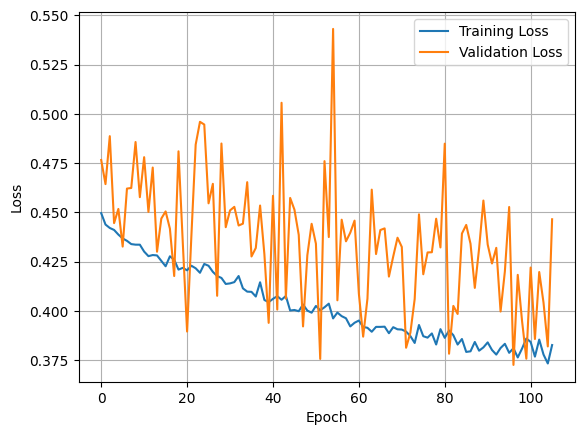

In [41]:
# plot training history
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

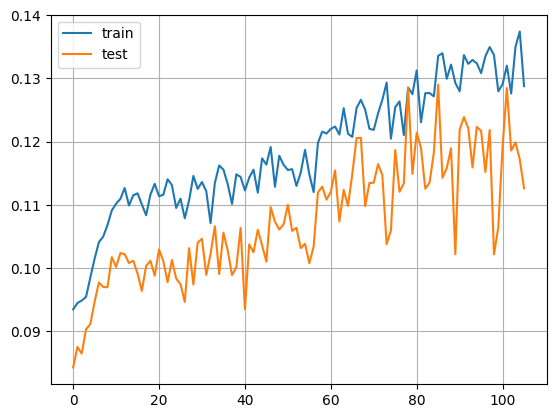

In [42]:
# plot training history
plt.plot(model_history.history['prc'], label='train')
plt.plot(model_history.history['val_prc'], label='test')
plt.legend()
plt.grid()
plt.show()

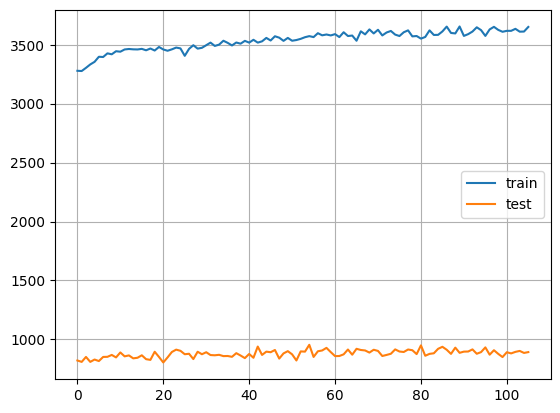

In [43]:
# plot training history
plt.plot(model_history.history['tp'], label='train')
plt.plot(model_history.history['val_tp'], label='test')
plt.legend()
plt.grid()
plt.show()

In [44]:
y_test_pred = model.predict(X_test)

2325/2325 [==============================] - 1s 512us/step


In [45]:
def fancy_confusion(cf_matrix, title):
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    plt.title(title)
    sns.heatmap(cf_matrix, annot=labels,cmap='YlOrRd',fmt="")
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

In [46]:
print("Perfect confusion matrix")
perfect_cf_matrix = confusion_matrix(y_test, y_test > 0.5)
print(perfect_cf_matrix)

Perfect confusion matrix
[[73341     0]
 [    0  1046]]


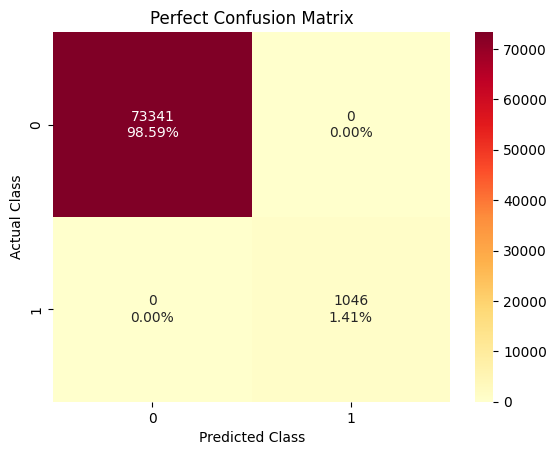

In [47]:
fancy_confusion(perfect_cf_matrix, 'Perfect Confusion Matrix')

In [48]:
print('AUPRC',average_precision_score(y_test, y_test_pred))
print('AUROC',roc_auc_score(y_test, y_test_pred))

print()
valid_cf_mat = confusion_matrix(y_test, y_test_pred > 0.5)
print(valid_cf_mat)

AUPRC 0.12656107853789644
AUROC 0.9000208056642505

[[53578 19763]
 [  109   937]]


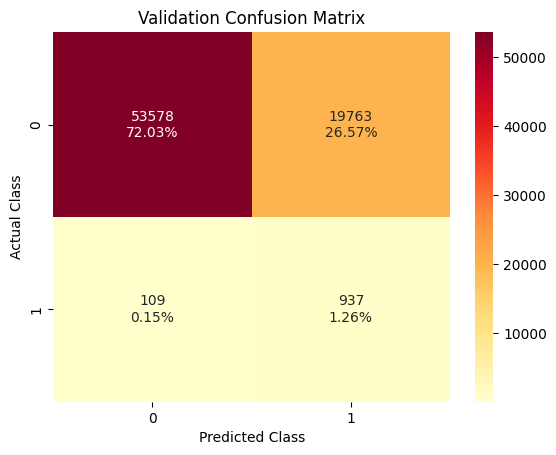

In [49]:
fancy_confusion(valid_cf_mat, 'Validation Confusion Matrix')

In [ ]:
print(classification_report(y_test, y_test_pred > 0.5))

In [ ]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

In [ ]:
plot_prc_and_roc(y_test, y_test_pred)

In [ ]:
get_scores_thresholds(X_test, y_test, model, algo="DNN")


In [ ]:
# model.save('thesis1_classifier')

### Re-fit on whole data!

In [ ]:
n_inputs = X.shape[1]  # (77862, 3)
print('Input shape',n_inputs)
model = make_model(n_inputs, metrics=METRICS)

In [ ]:
EPOCHS=25 #200
BATCH_SIZE=64# 2048
final_history = model.fit(X, y,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          shuffle=True) 

In [ ]:
# plot training history
plt.plot(final_history.history['loss'], label='train')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save('./Thesis/thesis4_classifier')

In [ ]:
# model = keras.models.load_model('./sim_final_full')
# 

In [ ]:
y_predict = model.predict(X)

In [ ]:
print(confusion_matrix(y, y > 0.5))

In [ ]:
fancy_confusion(confusion_matrix(y, y > 0.5), 'Perfect Data Confusion')

In [ ]:
print(confusion_matrix(y, y_predict > 0.5))

In [ ]:
fancy_confusion(confusion_matrix(y, y_predict > 0.5), ' Data Confusion')

In [ ]:
print(confusion_matrix(y, y_predict > 0.8))

In [ ]:
y.sum()